In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from IPython.display import display
from sklearn.model_selection import (GridSearchCV, ParameterGrid,
                                     RandomizedSearchCV)
from sklearn.metrics import fbeta_score, make_scorer
from xgboost import XGBClassifier
import pickle
import random
from tqdm.notebook import trange, tqdm
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from tools import (Modelisation, datasets, SearchCV, restauration_CV, 
                   graph_2scores_CV, graph_3scores_CV, graph_param_CV, 
                   best_score_CV)

## Matplotlib : 
# Pour affichage interactif (notamment 3D) dans notebook
# %matplotlib widget

# Pour affichage interactif (notamment 3D) dans une fenêtre qt externe au notebook
# %matplotlib qt

# Pour affichage simple dans notebook
# %config InlineBackend.figure_format = 'png'

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
datasets_df = datasets(df)
X_quant = datasets_df['X_quant']
X_cat = datasets_df['X_cat']
X = datasets_df['X']
y = datasets_df['y']

Columns_quant :


['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']


Columns_cat :


['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X : 63


In [4]:
len(y[y == 0]) / (len(y[y == 1]))

16.529395045803362

# XGBoost
## Variables quantitatives

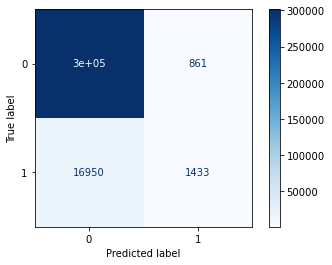

f1 : 0.1386
f3 : 0.0854
f5 : 0.0807
recall : 0.0780
negative predictive value : 0.9468
precision : 0.6247
roc_auc : 0.8254
training time : 22.699s
prediction time : 0.128s


In [5]:
m = Modelisation(X_quant, y, XGBClassifier(n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

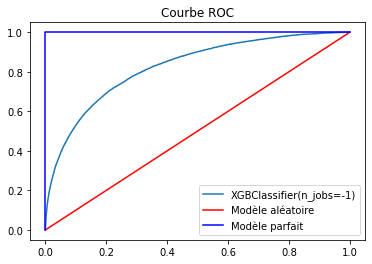

In [6]:
m.show_ROC()

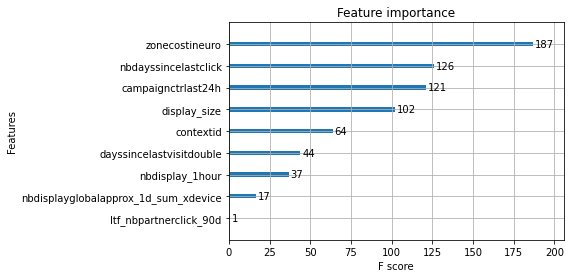

In [7]:
m.plot_importance()

Affichage d'un arbre (par défaut le premier parmi les autres) :

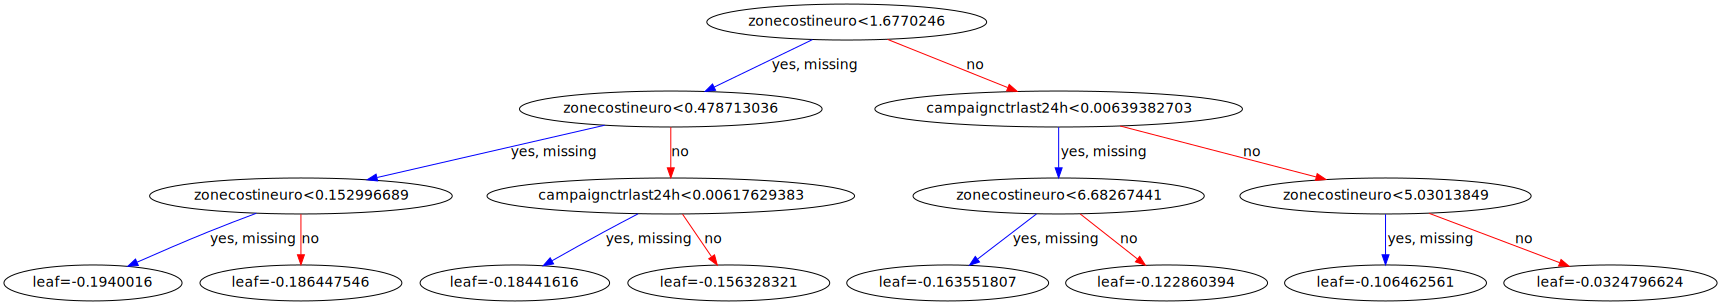

In [8]:
m.show_graph()

## Variables catégorielles

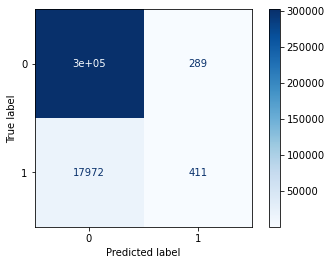

f1 : 0.0431
f3 : 0.0247
f5 : 0.0232
recall : 0.0224
negative predictive value : 0.9438
precision : 0.5871
roc_auc : 0.6899
training time : 23.221s
prediction time : 0.252s


In [9]:
m = Modelisation(X_cat, y, XGBClassifier(n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

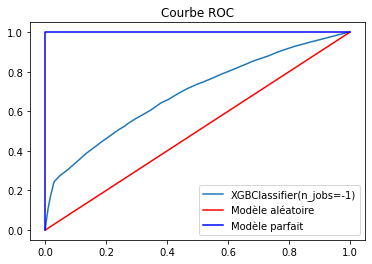

In [10]:
m.show_ROC()

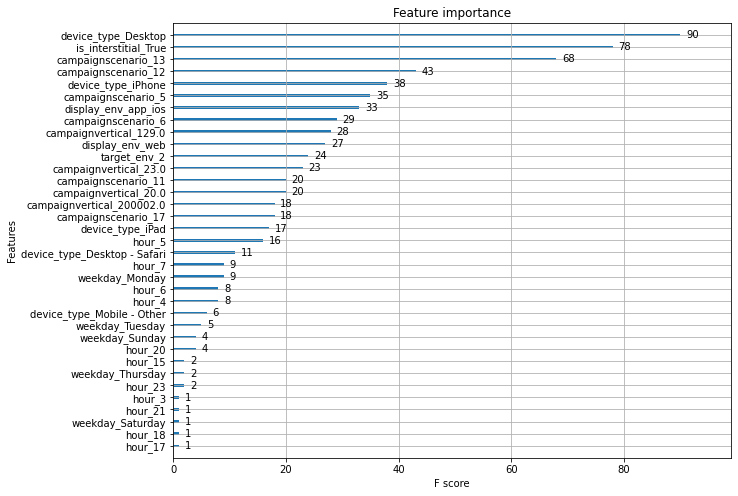

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
m.plot_importance(ax=ax)

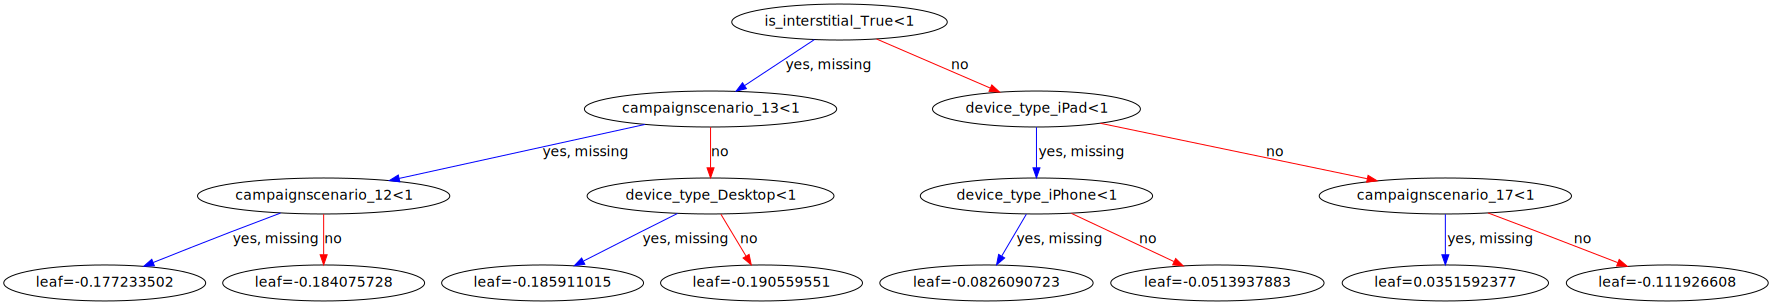

In [12]:
m.show_graph()

## Variables quantitatives + catégorielles

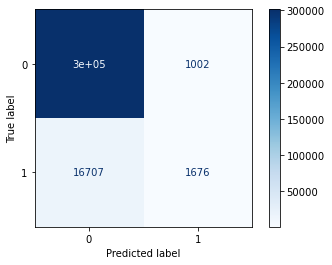

f1 : 0.1592
f3 : 0.0997
f5 : 0.0943
recall : 0.0912
negative predictive value : 0.9475
precision : 0.6258
roc_auc : 0.8324
training time : 33.036s
prediction time : 0.61s


In [13]:
m = Modelisation(X, y, XGBClassifier(n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

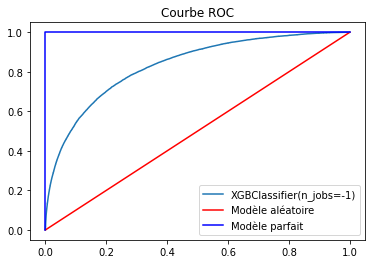

In [14]:
m.show_ROC()

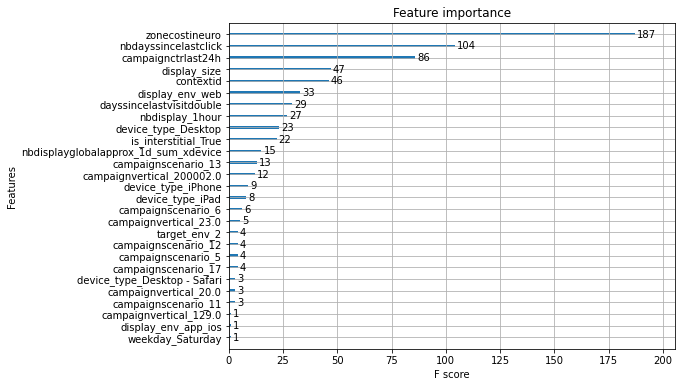

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
m.plot_importance(ax=ax)

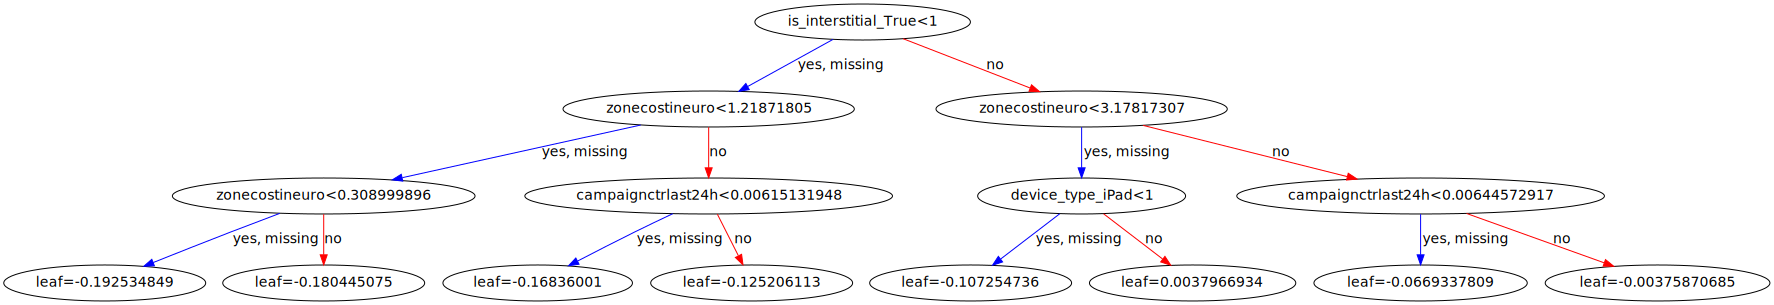

In [16]:
m.show_graph()

## Tuning des hyperparamètres avec GridSearchCV

On calcule le GridSearchCV sur un dataset plus petit pour avoir un temps de calcul raisonnable.

### Calcul et sauvegarde

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [17]:
len(y[y == 0]) / (len(y[y == 1]))

16.529395045803362

In [18]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', n_jobs=1)

cv_params = {
        'n_estimators': [50, 100, 150, 200, 300],    
        'max_depth': [2, 4, 6, 8, 10],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'min_child_weight': [1, 3, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],    
        'scale_pos_weight': [1, 16.5]   # A typical value to consider: sum(negative instances) / sum(positive instances)
        }

scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1',
           'f3': make_scorer(fbeta_score, beta=3),
           'f5': make_scorer(fbeta_score, beta=5)
          }

print(len(ParameterGrid(cv_params)))

54000


In [19]:
# SearchCV(model, cv_params, data_frac=0.02, random=True, n_iter=10000, scoring=scoring, random_state=1234, n_jobs=28)

### Restauration des résultats

In [20]:
dico, results = restauration_CV('XGBoost_CV_Randomized10000_54000_0.02')

model : XGBClassifier()
model_name : XGBoost
type : RandomizedSearchCV
len_grid : 54000
n_iter : 10000
data_frac : 0.02
temps : 6h, 59min, 48.726s
n_jobs : 28
params : {'n_estimators': [50, 100, 150, 200, 300], 'max_depth': [2, 4, 6, 8, 10], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'gamma': [0.5, 1, 1.5, 2, 5], 'min_child_weight': [1, 3, 5, 10], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'scale_pos_weight': [1, 16.5]}
scoring : {'recall': 'recall', 'precision': 'precision', 'f1': 'f1', 'f3': make_scorer(fbeta_score, beta=3), 'f5': make_scorer(fbeta_score, beta=5)}


In [21]:
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
0,5.026947,0.692788,0.061426,0.008451,1.0,1.0,150,1,2,0.1,...,1572,0.174826,0.024055,7249,0.112148,0.017129,7298,0.106289,0.016393,7299
1,5.769619,0.59993,0.059862,0.014458,0.6,16.5,150,3,2,0.01,...,8953,0.238627,0.005352,4445,0.49167,0.013866,1804,0.587533,0.01793,1416
2,5.109489,0.688776,0.05968,0.00946,1.0,1.0,50,5,8,0.1,...,1290,0.171878,0.023259,7344,0.109803,0.016258,7381,0.104028,0.015538,7382
3,5.988811,0.304419,0.072464,0.010179,1.0,1.0,200,5,2,0.1,...,1985,0.177445,0.027595,7143,0.114464,0.019513,7196,0.108542,0.018665,7197
4,19.836113,0.661145,0.09556,0.002889,0.8,1.0,300,1,4,0.01,...,590,0.129464,0.025709,8187,0.079486,0.017117,8196,0.075033,0.016277,8195
5,17.383768,1.263145,0.124539,0.010741,0.6,16.5,100,5,10,0.01,...,5563,0.315824,0.011513,126,0.444348,0.021314,3399,0.474064,0.024202,3553
6,17.483275,2.014449,0.096242,0.011861,0.6,1.0,150,10,6,0.3,...,4082,0.208002,0.026808,5091,0.14469,0.019607,5112,0.138221,0.018833,5116
7,37.590802,3.194246,0.306284,0.039169,1.0,16.5,200,3,10,0.01,...,5877,0.295771,0.019456,712,0.421735,0.029753,3758,0.451342,0.032571,3741
8,21.585008,3.045348,0.133525,0.02499,0.8,16.5,300,10,4,0.001,...,8591,0.251567,0.012816,4024,0.50987,0.018588,664,0.605629,0.019459,546
9,5.082194,0.911348,0.047326,0.006994,0.6,16.5,100,1,2,0.01,...,9075,0.231253,0.007048,4571,0.481757,0.018532,2230,0.578138,0.024268,1929


**Graphiques XY avec 2 scores**

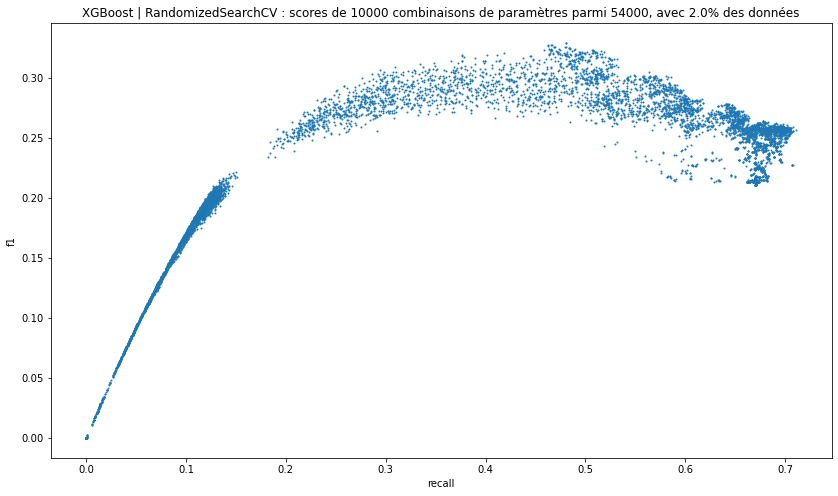

In [22]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=1)

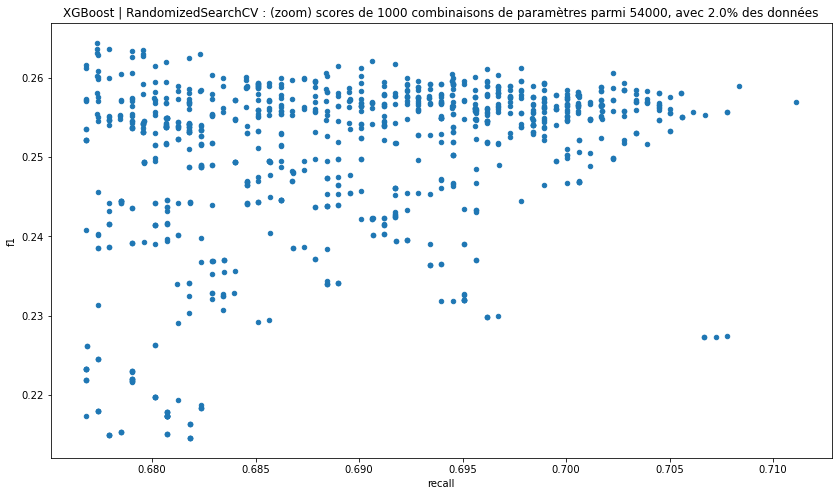

In [23]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=20, zoom=0.1)

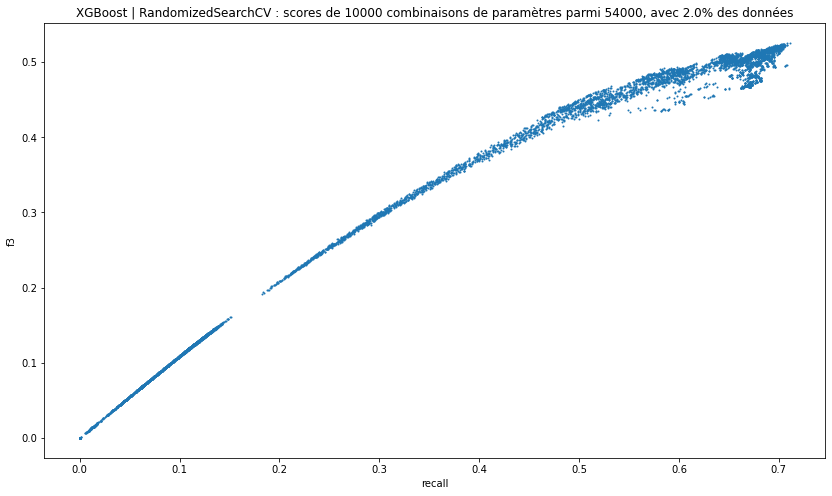

In [24]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=1)

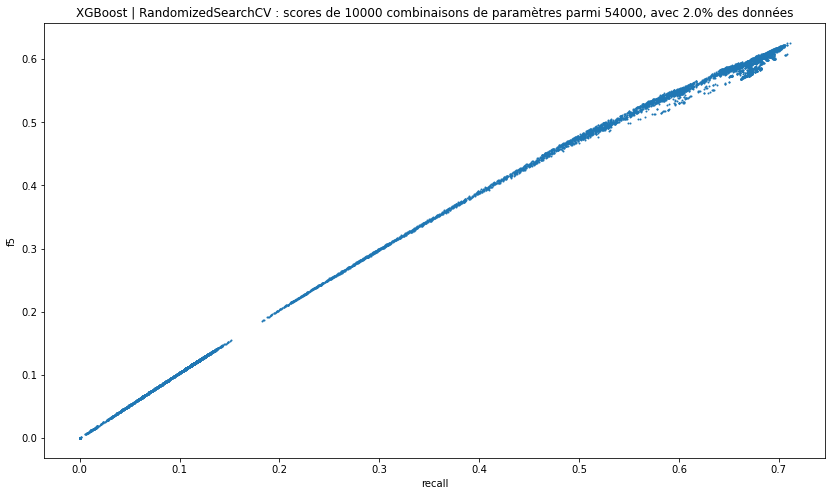

In [25]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=1)

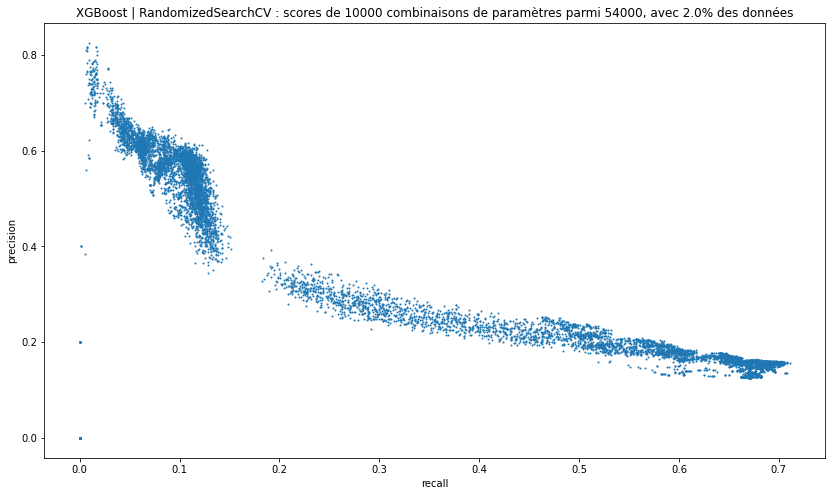

In [26]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=1)

**Graphique 3D avec 3 scores**

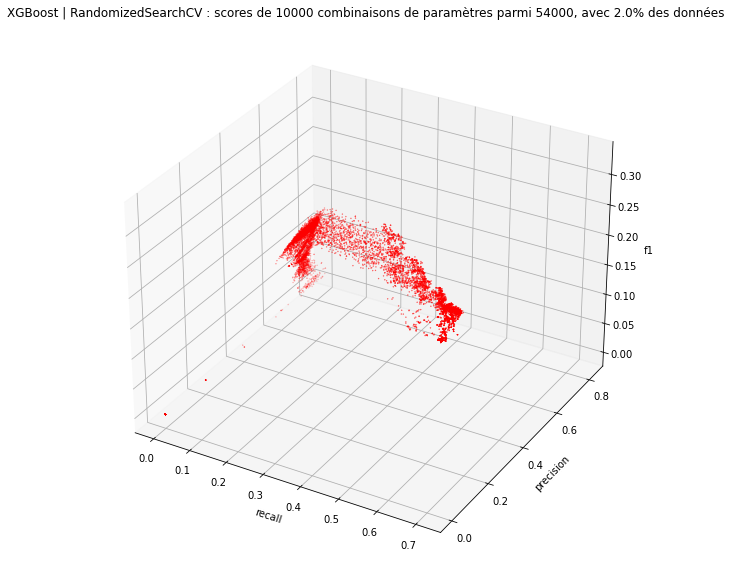

In [27]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=0.1)

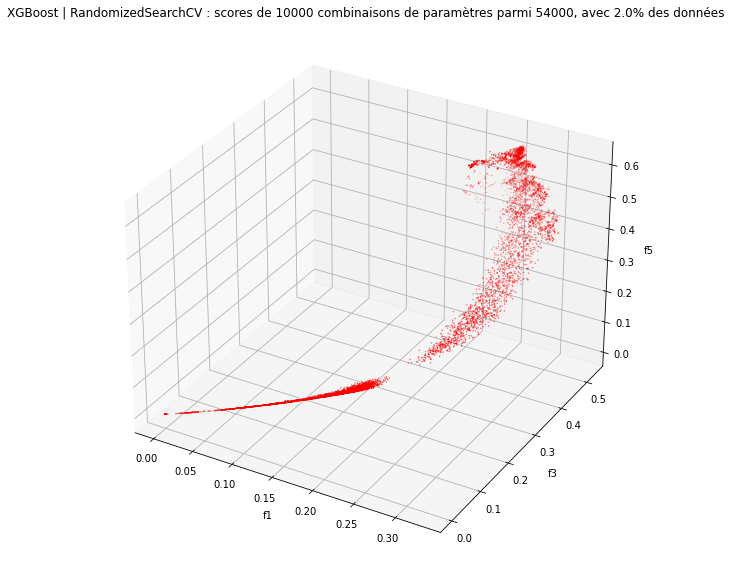

In [28]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=0.1)

**Graphiques de l'effet des paramètres**

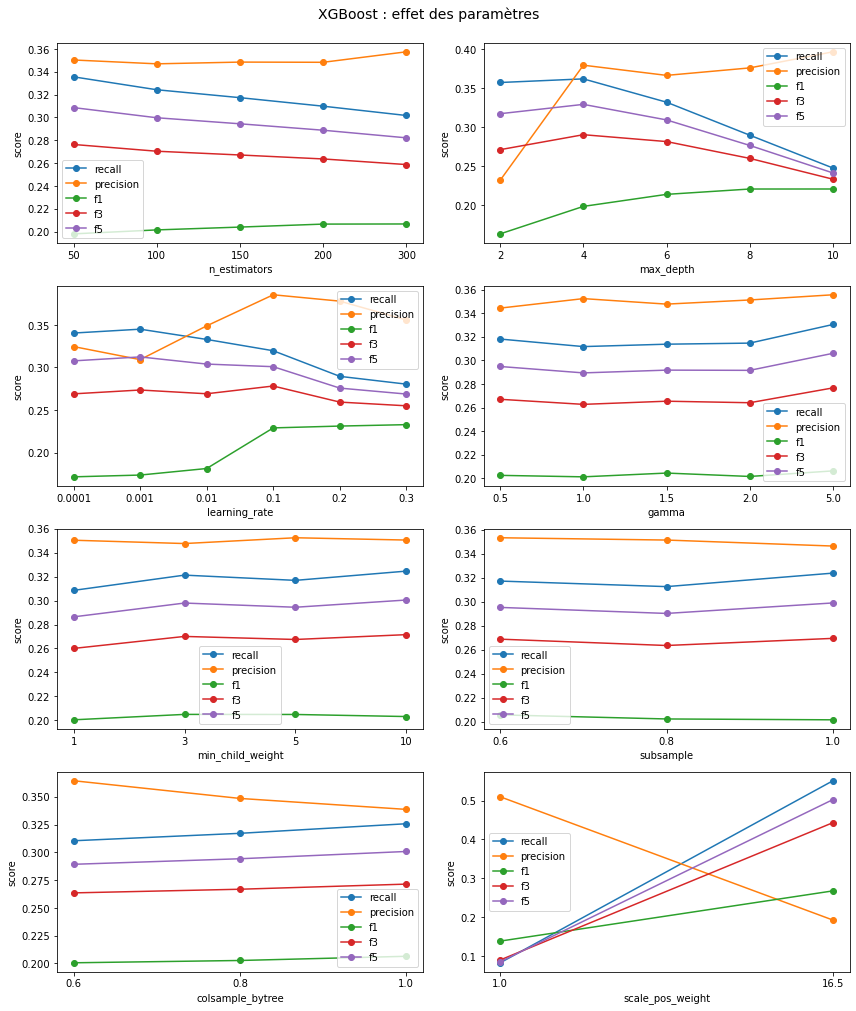

In [29]:
graph_param_CV(dico, results, ncols=2, height=3.5, width=6)

**Paramètres donnant le meilleur score**

In [30]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
9179,6.044308,0.091346,0.046985,0.002089,0.6,16.5,150,1,2,0.1,...,7961,0.258966,0.007413,3052,0.52584,0.014408,1,0.624922,0.016924,2
4407,3.383918,0.034965,0.037284,0.000476,0.6,16.5,100,10,2,0.1,...,8273,0.257012,0.00427,3374,0.525431,0.008435,2,0.626026,0.010246,1
9353,1.363027,0.04334,0.029539,0.001882,0.8,16.5,50,1,2,0.3,...,7711,0.260665,0.008574,2870,0.524506,0.017469,3,0.621271,0.021139,13
535,2.059184,0.345936,0.032875,0.006308,0.6,16.5,50,3,2,0.2,...,8074,0.258077,0.006034,3177,0.523879,0.013434,4,0.622528,0.016664,5
1032,1.94424,0.087838,0.032485,0.001858,0.6,16.5,50,3,2,0.2,...,8074,0.258077,0.006034,3177,0.523879,0.013434,4,0.622528,0.016664,5
3497,1.737698,0.241443,0.028802,0.000572,0.8,16.5,50,10,2,0.2,...,7854,0.259395,0.004179,2995,0.523748,0.008242,6,0.621134,0.009745,19
6116,2.119865,0.426842,0.031331,0.006074,0.8,16.5,50,3,2,0.3,...,8059,0.258123,0.007934,3166,0.523442,0.01449,7,0.621769,0.016511,10
5277,1.915105,0.040438,0.028321,0.000496,0.8,16.5,50,3,2,0.3,...,8059,0.258123,0.007934,3166,0.523442,0.01449,7,0.621769,0.016511,10
1021,1.697256,0.34013,0.032658,0.006131,1.0,16.5,50,10,2,0.2,...,8014,0.258331,0.003956,3138,0.523361,0.009823,9,0.621456,0.012563,12
251,6.740008,0.676747,0.053592,0.008681,0.6,16.5,150,3,2,0.1,...,8118,0.257621,0.009129,3253,0.523261,0.017229,10,0.62193,0.020035,8


Meilleure combinaison de paramètres pour f3 :


{'subsample': 0.6,
 'scale_pos_weight': 16.5,
 'n_estimators': 150,
 'min_child_weight': 1,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 1.5,
 'colsample_bytree': 1.0}

**Analyse sur la base complète**

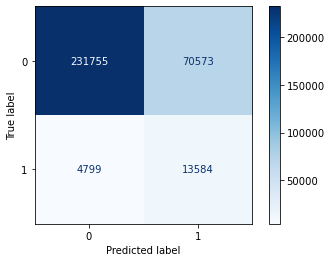

f1 : 0.2650
f3 : 0.5442
f5 : 0.6496
recall : 0.7389
negative predictive value : 0.9797
precision : 0.1614
roc_auc : 0.8326
training time : 33.457s
prediction time : 0.416s


In [31]:
m = Modelisation(X, y, XGBClassifier(**best_params, n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

Essayons avec le `learning_rate` par défaut :

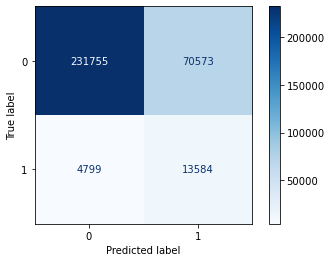

f1 : 0.2650
f3 : 0.5442
f5 : 0.6496
recall : 0.7389
negative predictive value : 0.9797
precision : 0.1614
roc_auc : 0.8326
training time : 35.088s
prediction time : 0.57s


In [32]:
if 'learning_rate' in best_params:
    del best_params['learning_rate']
m = Modelisation(X, y, XGBClassifier(**best_params, n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

Nous reproduisons le graphique f1 vs recall en prenant 10% des meilleures combinaisons (selon le recall), en fittant le modèle sur 10% des données.

  0%|          | 0/25 [00:00<?, ?it/s]

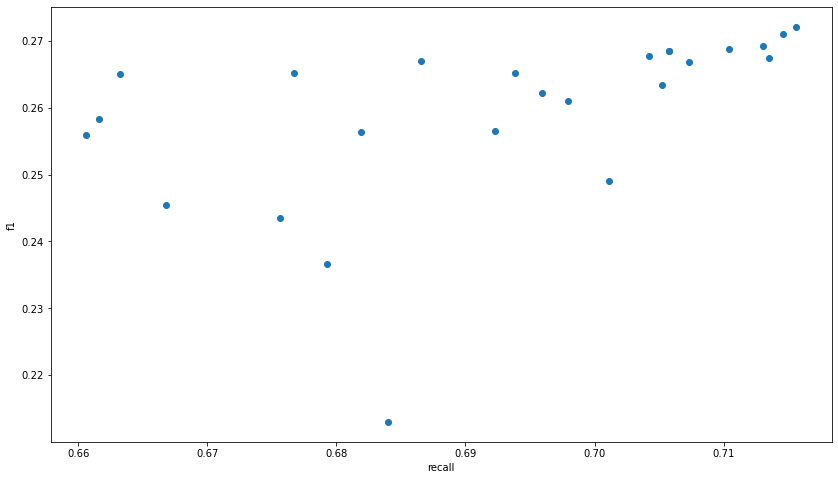

CPU times: user 4h 47min 52s, sys: 1min 4s, total: 4h 48min 56s
Wall time: 6min 49s


In [33]:
%%time

df_small = pd.read_csv('data/df_train_prepro.csv').sample(frac=0.1)
datasets_df_small = datasets(df_small, verbose=False)
X_small = datasets_df_small['X']
y_small = datasets_df_small['y']

f1_list = []
recall_list = []
params_list = []


results_sort = results.sort_values(by=f'mean_test_recall', ascending=False)


nb_tot = int(0.10 * len(results))
nb = 25

random.seed(1)
sample = random.sample(list(range(nb_tot)), nb)
for j in trange(nb):
    i = sample[j]
    params = results_sort.iloc[i].params
    m = Modelisation(X_small, y_small, XGBClassifier(**params, n_jobs=-1), scaling=False)
    params_list.append(params)
    f1_list.append(m.metrics_score['f1'])
    recall_list.append(m.metrics_score['recall'])
    
plt.figure(figsize=(14, 8))
plt.scatter(recall_list, f1_list, marker='o')
plt.xlabel('recall')
plt.ylabel('f1')
plt.show()
 
# dico_ = {'params': params_list, 'f1': f1_list, 'recall': recall_list}     
# r = pd.DataFrame(dico_).sort_values(by='recall', ascending=False)

Même graphique avec le `learning_rate` par défaut :

  0%|          | 0/25 [00:00<?, ?it/s]

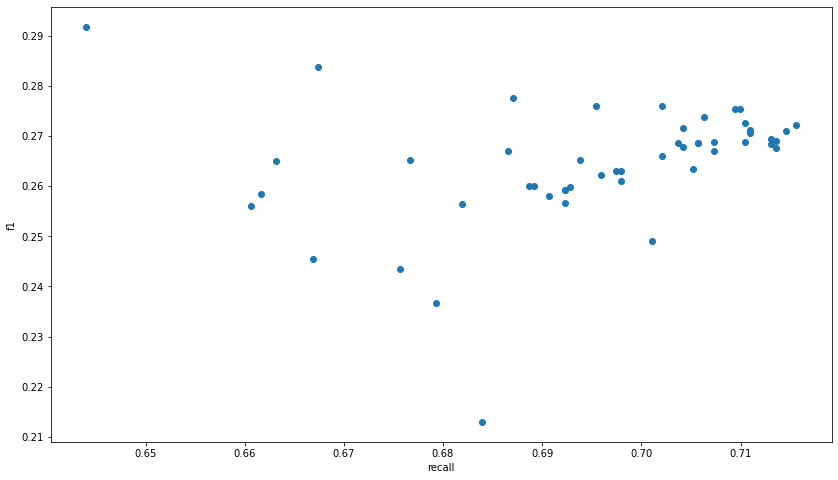

CPU times: user 6h 10min 22s, sys: 1min 22s, total: 6h 11min 45s
Wall time: 8min 36s


In [34]:
%%time

sample = random.sample(list(range(nb_tot)), nb)
for j in trange(nb):
    i = sample[j]
    params = results_sort.iloc[i].params
    if 'learning_rate' in params:
        del params['learning_rate']
    m = Modelisation(X_small, y_small, XGBClassifier(**params, n_jobs=-1), scaling=False)
    params_list.append(params)
    f1_list.append(m.metrics_score['f1'])
    recall_list.append(m.metrics_score['recall'])
    
plt.figure(figsize=(14, 8))
plt.scatter(recall_list, f1_list, marker='o')
plt.xlabel('recall')
plt.ylabel('f1')
plt.show()

**Test de paramètres**

In [35]:
params = {'colsample_bytree': 1.0, 
          'gamma': 1,
          'min_child_weight': 15,
          'scale_pos_weight': 16.5, 
          'subsample': 0.8}

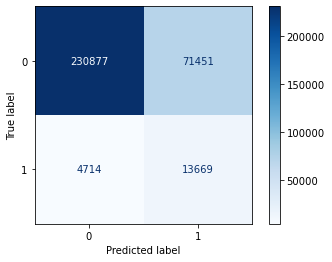

f1 : 0.2641
f3 : 0.5455
f5 : 0.6525
recall : 0.7436
negative predictive value : 0.9800
precision : 0.1606
roc_auc : 0.8336
training time : 37.529s
prediction time : 0.615s


In [36]:
m = Modelisation(X, y, XGBClassifier(**params, n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

## Oversampling

In [37]:
over = RandomOverSampler(random_state=1234)

pipeline = Pipeline_imb([
            ('over', over),
            ('model', XGBClassifier(booster='gbtree', objective='binary:logistic', n_jobs=1))
            ])

cv_params = {
        "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
        "model__n_estimators": [50, 100, 150, 200, 300],    
        "model__max_depth": [2, 4, 6, 8, 10],
        "model__learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
        "model__gamma": [0.5, 1, 1.5, 2, 5],
        "model__min_child_weight": [1, 3, 5, 10],
        "model__subsample": [0.6, 0.8, 1.0],
        "model__colsample_bytree": [0.6, 0.8, 1.0],    
        "model__scale_pos_weight": [1, 16.5]   # A typical value to consider: sum(negative instances) / sum(positive instances)
        }

scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1',
           'f3': make_scorer(fbeta_score, beta=3),
           'f5': make_scorer(fbeta_score, beta=5)
          }

print(len(ParameterGrid(cv_params)))

324000


In [38]:
# SearchCV(pipeline, cv_params, data_frac=0.02, random=True, n_iter=20000, scoring=scoring, random_state=1234, n_jobs=28)

In [39]:
dico, results = restauration_CV('RandomOver_XGBoost_CV_Randomized20000_324000_0.02')

model : Pipeline(steps=[('over', RandomOverSampler(random_state=1234)),
                ('model', XGBClassifier())])
model_name : RandomOver_XGBoost
type : RandomizedSearchCV
len_grid : 324000
n_iter : 20000
data_frac : 0.02
temps : 21h, 16min, 8.291s
n_jobs : 28
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'model__n_estimators': [50, 100, 150, 200, 300], 'model__max_depth': [2, 4, 6, 8, 10], 'model__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'model__gamma': [0.5, 1, 1.5, 2, 5], 'model__min_child_weight': [1, 3, 5, 10], 'model__subsample': [0.6, 0.8, 1.0], 'model__colsample_bytree': [0.6, 0.8, 1.0], 'model__scale_pos_weight': [1, 16.5]}
scoring : {'recall': 'recall', 'precision': 'precision', 'f1': 'f1', 'f3': make_scorer(fbeta_score, beta=3), 'f5': make_scorer(fbeta_score, beta=5)}


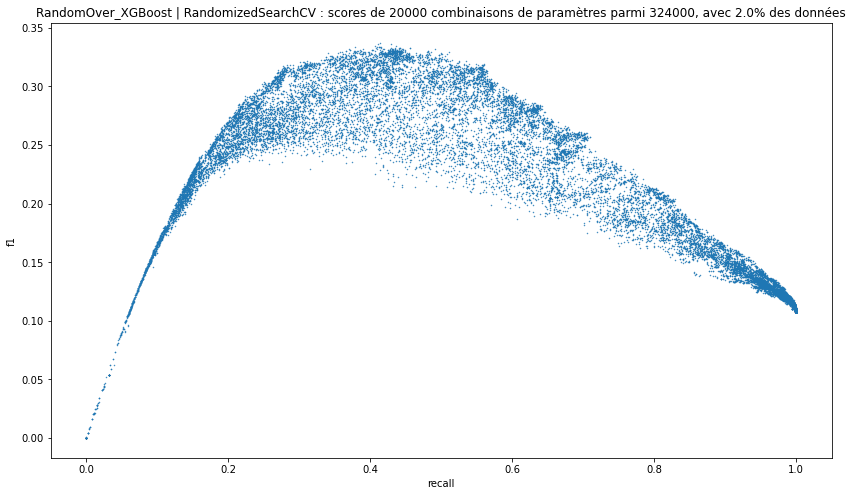

In [40]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=0.2)

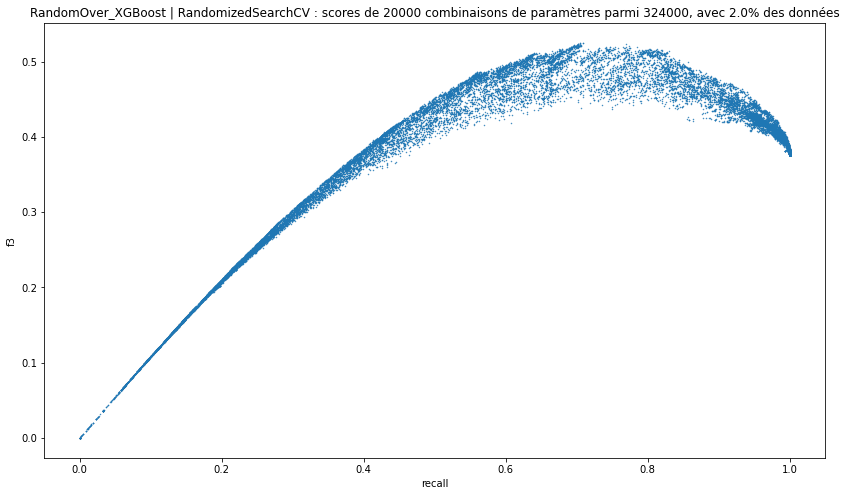

In [41]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=0.2)

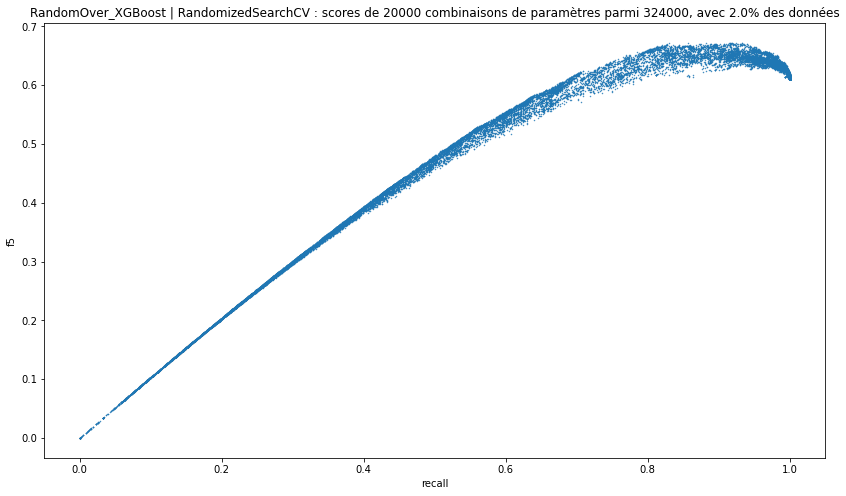

In [42]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=0.2)

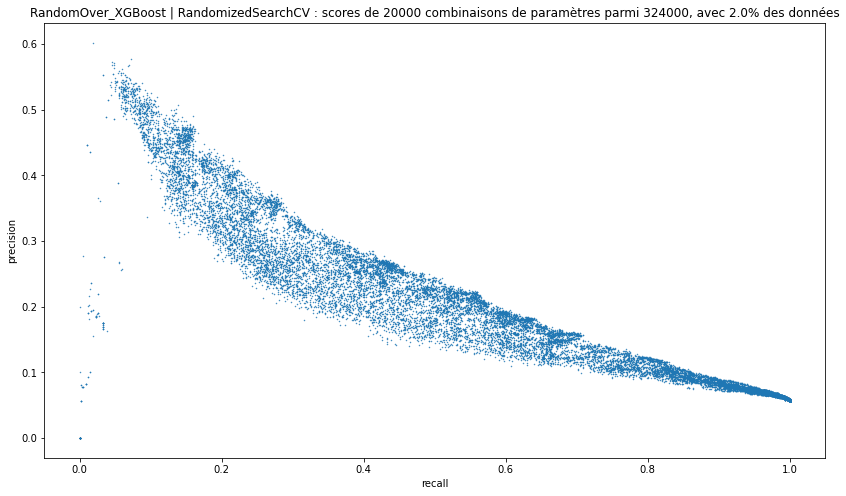

In [43]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=0.2)

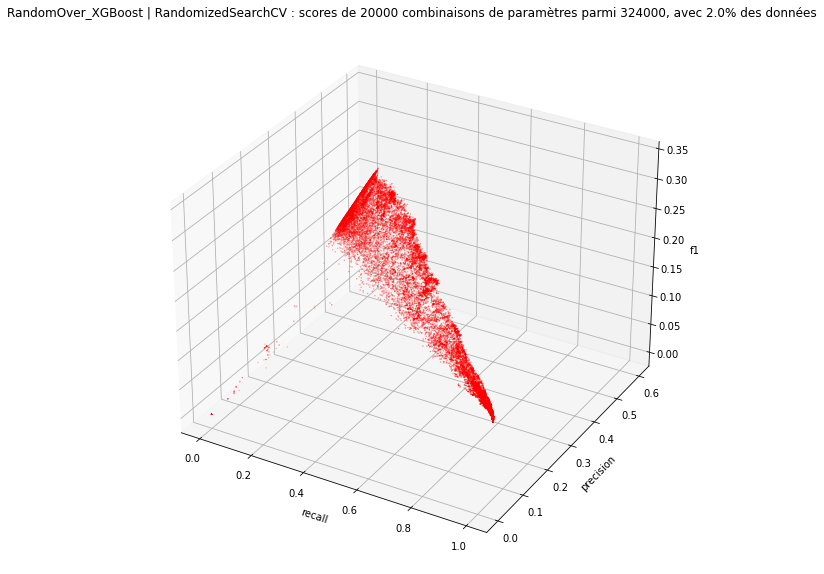

In [44]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=0.05)

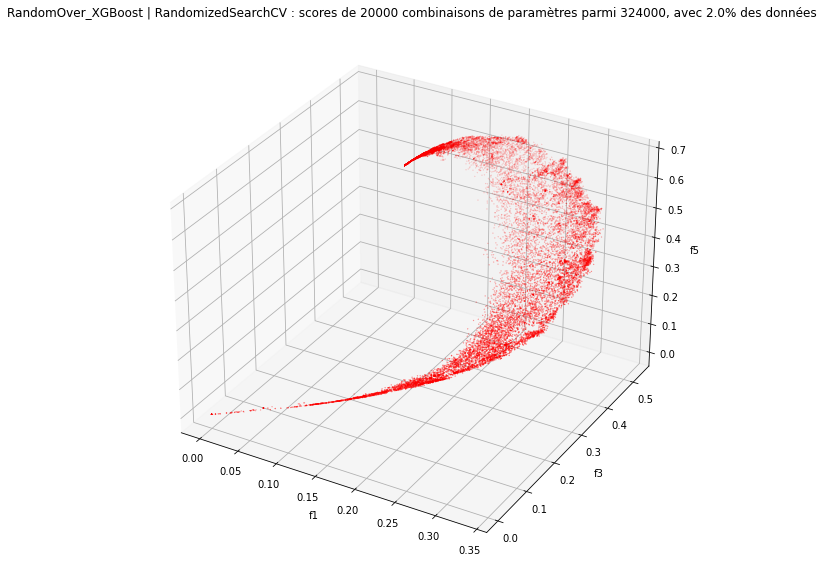

In [45]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=0.05)

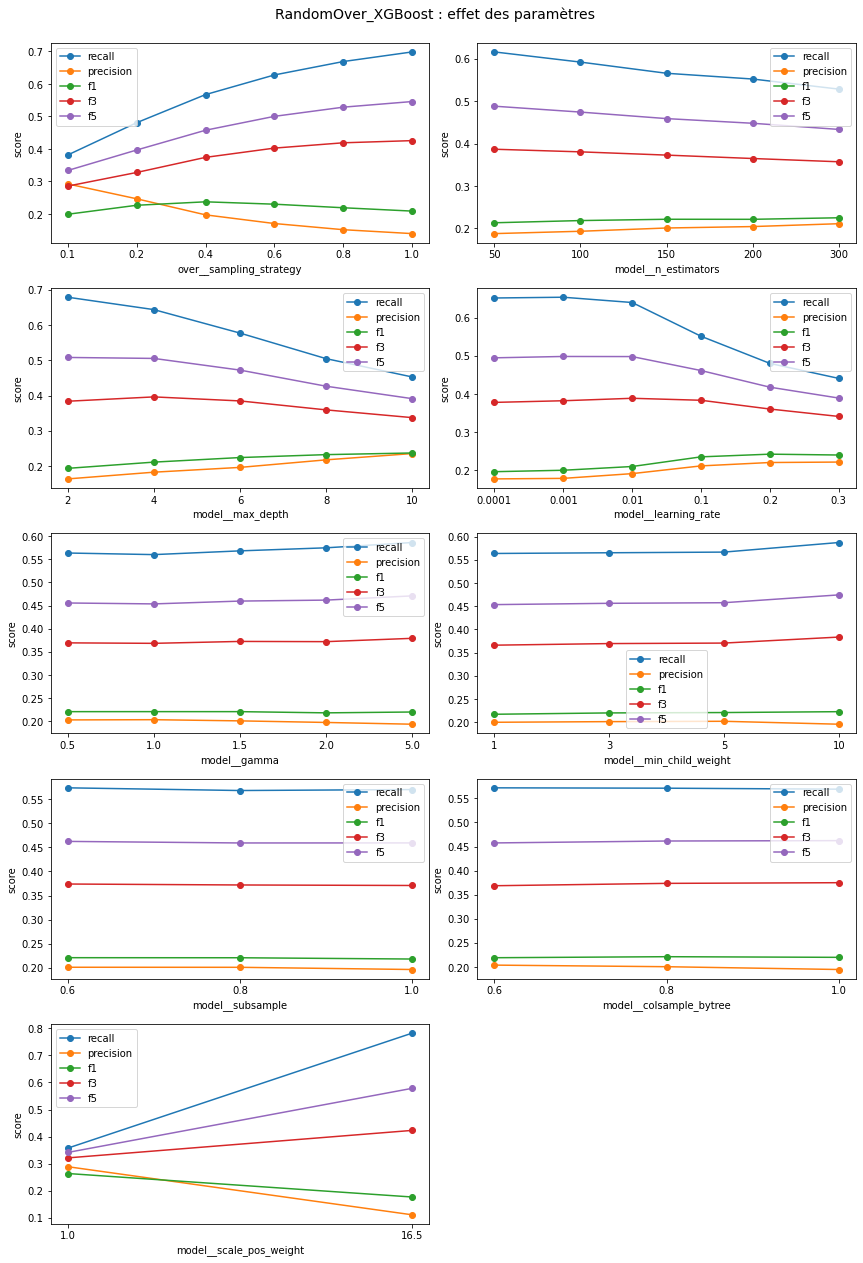

In [46]:
graph_param_CV(dico, results, ncols=2, height=3.5, width=6)

In [47]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_over__sampling_strategy,param_model__subsample,param_model__scale_pos_weight,param_model__n_estimators,param_model__min_child_weight,param_model__max_depth,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
3603,10.203873,0.25729,0.053364,0.000863,1.0,1.0,1.0,200,5,2,...,11037,0.260403,0.008223,7186,0.525172,0.012458,1,0.622628,0.014307,5636
14203,8.111197,1.47025,0.044712,0.009016,1.0,0.6,1.0,100,10,2,...,11085,0.259915,0.005861,7249,0.525066,0.009514,2,0.622842,0.010948,5618
18171,4.483375,0.766105,0.030214,0.001033,1.0,0.6,1.0,50,5,2,...,11294,0.256745,0.008114,7720,0.524338,0.016307,3,0.624535,0.020385,5462
12664,4.845676,0.622448,0.033886,0.008209,1.0,0.6,1.0,50,5,2,...,11294,0.256745,0.008114,7720,0.524338,0.016307,3,0.624535,0.020385,5462
1046,12.775738,0.249171,0.055521,0.004575,1.0,0.6,1.0,200,3,2,...,11055,0.260001,0.006245,7243,0.523643,0.010938,5,0.620486,0.013573,5783
19022,23.34914,0.234762,0.179702,0.003698,0.1,0.6,16.5,300,10,6,...,12413,0.229808,0.006666,10356,0.523537,0.010876,6,0.651764,0.01262,1560
12282,12.365341,1.900852,0.068049,0.011796,1.0,1.0,1.0,200,10,2,...,11136,0.259086,0.00613,7361,0.523133,0.008071,7,0.620469,0.009295,5784
9685,11.246469,1.493251,0.058201,0.008766,1.0,1.0,1.0,200,10,2,...,11136,0.259086,0.00613,7361,0.523133,0.008071,7,0.620469,0.009295,5784
12826,3.886513,0.765378,0.032777,0.00696,1.0,1.0,1.0,50,3,2,...,11234,0.257551,0.007661,7585,0.523122,0.013978,9,0.621788,0.016508,5706
18783,12.160737,0.996215,0.050785,0.001466,1.0,0.8,1.0,200,3,2,...,11109,0.259354,0.007757,7321,0.523104,0.01296,10,0.620191,0.015452,5801


Meilleure combinaison de paramètres pour f3 :


{'over__sampling_strategy': 1,
 'model__subsample': 1.0,
 'model__scale_pos_weight': 1,
 'model__n_estimators': 200,
 'model__min_child_weight': 5,
 'model__max_depth': 2,
 'model__learning_rate': 0.1,
 'model__gamma': 0.5,
 'model__colsample_bytree': 0.8}

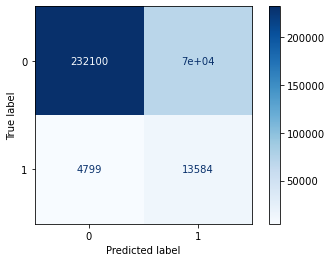

f1 : 0.2658
f3 : 0.5450
f5 : 0.6500
recall : 0.7389
negative predictive value : 0.9797
precision : 0.1621
roc_auc : 0.8338
training time : 1min, 10.153s
prediction time : 0.584s


In [48]:
best_params['model__n_jobs'] = -1
m = Modelisation(X, y, pipeline.set_params(**best_params), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

In [49]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:21:06
